In [1]:
!python -V

Python 3.9.23


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("nyc-taxi-experiment")

2025/07/11 19:17:33 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/11 19:17:33 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/mike-adamski/Dev/projects/learning-mlops/mlruns/1', creation_time=1752278224330, experiment_id='1', last_update_time=1752278224330, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2025-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

6.704280605646082

/tmp/ipykernel_47421/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_47421/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


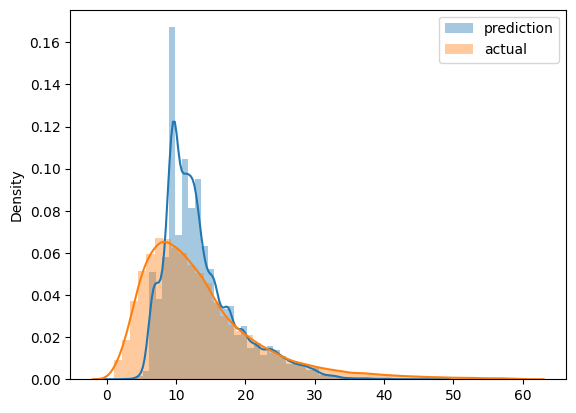

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2025-02.parquet')

In [12]:
len(df_train), len(df_val)

(46307, 44218)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.098876680252939

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():

    mlflow.set_tag('developer', 'mike')
    mlflow.log_param('train_data_path', 'data/green_tripdata_2025-01.parquet')
    mlflow.log_param('val_data_path', 'data/green_tripdata_2025-02.parquet')


    learning_rate = 0.001
    mlflow.log_param('learning_rate', learning_rate)
    lr = Lasso(learning_rate)
    
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

In [23]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [ ]:
best_hyperparams = {
    'learning_rate': 0.1056041977474679,
    'max_depth': 18,
    'min_child_weight': 2.13610085052269,
    'objective': 'reg:linear',
    'reg_alpha': 0.1597148515376788,
    'reg_lambda': 0.20015423386743114,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_hyperparams,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

with open('models/preprocessor.b', 'wb') as f_out:
    pickle.dump(dv, f_out)

mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')

mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

[0]	validation-rmse:8.52507


/home/mike-adamski/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:32:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:8.02874
[2]	validation-rmse:7.60778
[3]	validation-rmse:7.25168
[4]	validation-rmse:6.95072
[5]	validation-rmse:6.69725
[6]	validation-rmse:6.48508
[7]	validation-rmse:6.31089
[8]	validation-rmse:6.16480
[9]	validation-rmse:6.04025
[10]	validation-rmse:5.94092
[11]	validation-rmse:5.85589
[12]	validation-rmse:5.78526
[13]	validation-rmse:5.72691
[14]	validation-rmse:5.67828
[15]	validation-rmse:5.63738
[16]	validation-rmse:5.60317
[17]	validation-rmse:5.57450
[18]	validation-rmse:5.54973
[19]	validation-rmse:5.52963
[20]	validation-rmse:5.51164
[21]	validation-rmse:5.49692
[22]	validation-rmse:5.48270
[23]	validation-rmse:5.47113
[24]	validation-rmse:5.46069
[25]	validation-rmse:5.45314
[26]	validation-rmse:5.44496
[27]	validation-rmse:5.43848
[28]	validation-rmse:5.43333
[29]	validation-rmse:5.42741
[30]	validation-rmse:5.42286
[31]	validation-rmse:5.41996
[32]	validation-rmse:5.41756
[33]	validation-rmse:5.41379
[34]	validation-rmse:5.41176
[35]	validation-rmse:5.

2025/07/12 20:32:30 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/07/12 20:32:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/12 20:32:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mike-adamski/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:32:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/07/12 20:32:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/12 20:32:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error dur